# Building Autoencoders with Keras

### What are Autoencoders ?
![autoencoder_schema](autoencoder_schema.jpg "autoencoder_schema")

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

* Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

* Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

* Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

## We'll start simple, with a single fully-connected neural layer as encoder and as decoder:


In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input, here we take the input_image as input tensor
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input here we take the encodeed as input tensor
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


## Let's also create a separate encoder model:

In [2]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## As well as the decoder model:

In [3]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Now let's train our autoencoder to reconstruct MNIST digits.

### First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [4]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

## Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11476992/11490434 [============================>.] - ETA: 0s

## We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.


In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


## Now let's train our autoencoder for 50 epochs:

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s - loss: 0.3831 - val_loss: 0.2742
Epoch 2/50
60000/60000 [==============================] - 6s - loss: 0.2679 - val_loss: 0.2586
Epoch 3/50
60000/60000 [==============================] - 5s - loss: 0.2492 - val_loss: 0.2372
Epoch 4/50
60000/60000 [==============================] - 6s - loss: 0.2291 - val_loss: 0.2185
Epoch 5/50
60000/60000 [==============================] - 4s - loss: 0.2126 - val_loss: 0.2045
Epoch 6/50
60000/60000 [==============================] - 6s - loss: 0.2007 - val_loss: 0.1943
Epoch 7/50
60000/60000 [==============================] - 6s - loss: 0.1916 - val_loss: 0.1864
Epoch 8/50
60000/60000 [==============================] - 5s - loss: 0.1844 - val_loss: 0.1799
Epoch 9/50
60000/60000 [==============================] - 7s - loss: 0.1783 - val_loss: 0.1741
Epoch 10/50
60000/60000 [==============================] - 6s - loss: 0.1729 - val_loss: 0.1691

## After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.



In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

## lets see the encoded features

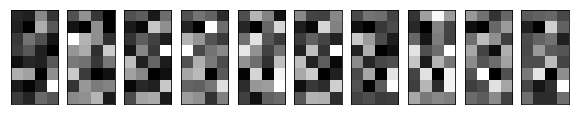

In [42]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display encoded
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(-1, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

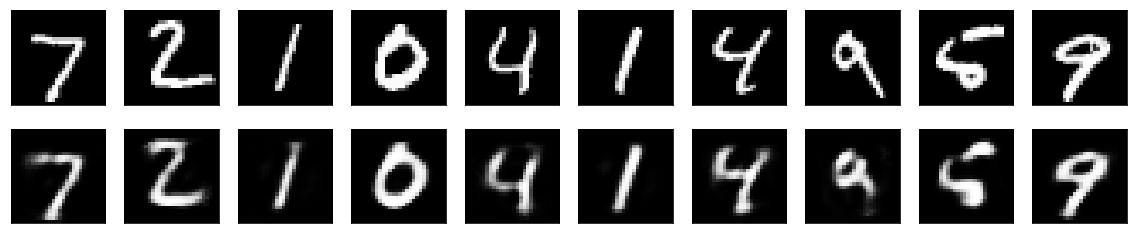

In [43]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

